## 「ベイズ推論による機械学習入門」P.133 ポアソン混合モデルにおける変分推論

In [1]:
using Distributions
using Plots
using StatsBase
using SpecialFunctions: digamma

const ψ = digamma

digamma (generic function with 2 methods)

## 真のモデル

In [2]:
λ_true = [10.0, 25.0, 40.0]
π_true = [0.35, 0.3, 0.35]
true_model = MixtureModel([Poisson(λ) for λ in λ_true], π_true)

MixtureModel{Poisson{Float64}}(K = 3)
components[1] (prior = 0.3500): Poisson{Float64}(λ=10.0)
components[2] (prior = 0.3000): Poisson{Float64}(λ=25.0)
components[3] (prior = 0.3500): Poisson{Float64}(λ=40.0)


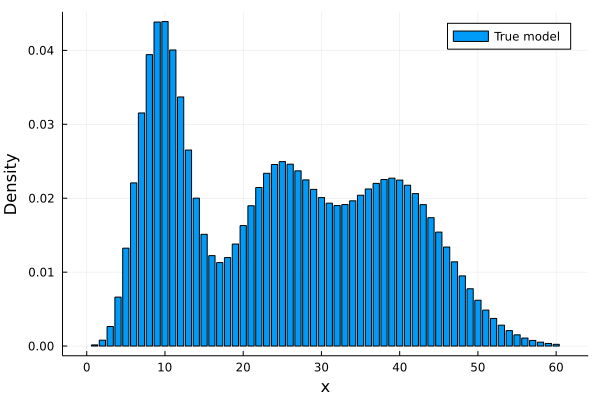

In [3]:
bar(x -> pdf(true_model, x), 1:60, label="True model", xlabel="x", ylabel="Density")

## 観測データを生成

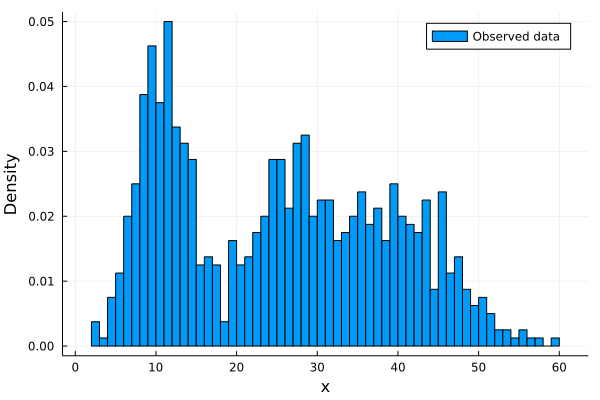

In [4]:
N = 800
mult_obs = Multinomial(1, π_true)
S_obs = rand(mult_obs, N)
cluster_num = mapslices(argmax, S_obs, dims=1)

data = Float64[]
for (idx, val) in enumerate(λ_true)
    n = count(cluster_num .== idx)
    poi_obs = Poisson(val)
    data = vcat(data, rand(poi_obs, n))
end

bins = 80
histogram(data; bins, label="Observed data", xlabel="x", ylabel="Density", norm=:pdf)

## 変分推論

In [58]:
N = 800
K = 3
max_iter = 100

λ_sample = zeros(max_iter+1, K)
π_sample = zeros(max_iter+1, K)

â = ones(max_iter+1, K)
b̂ = ones(max_iter+1, K)
α̂ = ones(max_iter+1, K);

### Sの近似分布に対する更新式

In [59]:
E_lnλ = ψ.(â[1, :]) .- log.(b̂[1, :])
E_λ = â[1, :] ./ b̂[1, :]
η_ = exp.(data' .* E_lnλ .- E_λ) # \eta + <TAB>
η = η_ ./ sum(η_, dims=1)

3×800 Matrix{Float64}:
 0.333333  0.333333  0.333333  0.333333  …  0.333333  0.333333  0.333333
 0.333333  0.333333  0.333333  0.333333     0.333333  0.333333  0.333333
 0.333333  0.333333  0.333333  0.333333     0.333333  0.333333  0.333333

In [60]:
s_sample = zeros(3, 800)
for n in 1:800
    cat = Multinomial(1, η[:, n])
    s_sample[:, n] = rand(cat, 1)
end
s_sample

3×800 Matrix{Float64}:
 1.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  …  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  1.0

### $\lambda$の近似分布に対する更新式

In [61]:
â[2, :] += sum(η .* data', dims=2)
b̂[2, :] += sum(η, dims=2);

In [67]:
for k in 1:K
    gam = Gamma(â[2, k], 1 ./ b̂[2, k])
    λ_sample[1, k] = rand(gam, 1)[1]
end
λ_sample[1:3, :]

3×3 Matrix{Float64}:
 24.7173  25.0176  25.1498
  0.0      0.0      0.0
  0.0      0.0      0.0

### $\pi$の近似分布に対する更新式

In [69]:
α̂[1, :] += sum(η, dims=2)
α̂[1:3, :]

3×3 Matrix{Float64}:
 534.333  534.333  534.333
   1.0      1.0      1.0
   1.0      1.0      1.0

In [74]:
dir = Dirichlet(α̂[1, :])
π_sample[1, :] = rand(dir, 1)
π_sample[1:3, :]

3×3 Matrix{Float64}:
 0.335656  0.332249  0.332095
 0.0       0.0       0.0
 0.0       0.0       0.0

### まとめ

In [12]:
N = 800
K = 3
max_iter = 100

λ_sample = zeros(max_iter, K)
π_sample = zeros(max_iter, K)

â = ones(max_iter+1, K)
b̂ = ones(max_iter+1, K)
α̂ = ones(max_iter+1, K);

for i in 1:max_iter
    E_lnλ = ψ.(â[i, :]) .- log.(b̂[i, :])
    E_λ = â[i, :] ./ b̂[i, :]
    η_ = exp.(data' .* E_lnλ .- E_λ)
    η = η_ ./ sum(η_, dims=1)
    s_sample = zeros(K, N)
    for n in 1:N
        cat = Multinomial(1, η[:, n])
        s_sample[:, n] = rand(cat, 1)
    end
　　
    â[i+1, :] += sum(s_sample .* data', dims=2)
    b̂[i+1, :] += sum(s_sample, dims=2)
    for k in 1:K
        gam = Gamma(â[i+1, k], 1 ./ b̂[i+1, k])
        λ_sample[i, k] = rand(gam, 1)[1]
    end
　　
    α̂[i, :] += sum(s_sample, dims=2)
    dir = Dirichlet(α̂[:])
    π_sample[i+1, :] = rand(dir, 1)
    
    if i % 10 == 1
        println("iteration: $i")
    end
end

3×800 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  0.0  0.0  1.0

## サンプルしたパラメータを使って分布を確認

In [7]:
#xs = 1:60
#anim = @animate for i in 1:max_iter
#    p = histogram(data; bins, norm=:pdf, label="Observed data", xlabel="x", ylabel="Density")
#    d = MixtureModel([Poisson(λ) for λ in λ_sample[i, :]], π_sample[i, :])
#    p = plot!(xs, pdf(d, xs), label="Pred model", linewidth=2, color="purple")
#end

#gif(anim, "vi_poisson.gif", fps=10)